This project is the result of my solution for a hackathon at Zindi. In this project, we develop Catboot, Xgb, and LightGBM models for comparison using different tuning parameters just hato have a feel of how they behave.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from lightgbm import LGBMRegressor
from pathlib import Path

pd.set_option('display.max_columns', None)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
DATA_PATH = Path('')

# Load files
train = pd.read_csv(DATA_PATH / 'Train.csv', index_col='date')
train.index = pd.to_datetime(train.index, format="%Y-%m-%d")

test = pd.read_csv(DATA_PATH / 'Test.csv', index_col='date')
test.index = pd.to_datetime(test.index, format="%Y-%m-%d")

sample_submission = pd.read_csv(DATA_PATH / 'SampleSubmission.csv')

In [4]:
train.head()

,id,site_id,site_latitude,site_longitude,city,country,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-25,id_vjcx08sz91,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052301,828817.9375,-100.805145,21.720518,-123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,-100.805145,21.720518,-123.523796,33.745914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000
2023-11-02,id_bkg215syli,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,0.045475,3771.027210,3399.756845,828569.623806,69.245351,59.159695,-143.370575,26.566997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000214,1.462390,0.000240,0.359150,26.525513,-143.480164,59.220097,70.875954,-0.315206,828578.6250,70.875954,59.220097,-143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,-143.480164,26.525513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200
2023-11-03,id_oui2pot3qd,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.097816,828878.6875,-96.411942,61.045010,-121.307121,41.898113,0.117559,3.248703,0.384168,224.102463,0.754163,-

In [5]:
test.shape, train.shape

((2783, 78), (8071, 79))

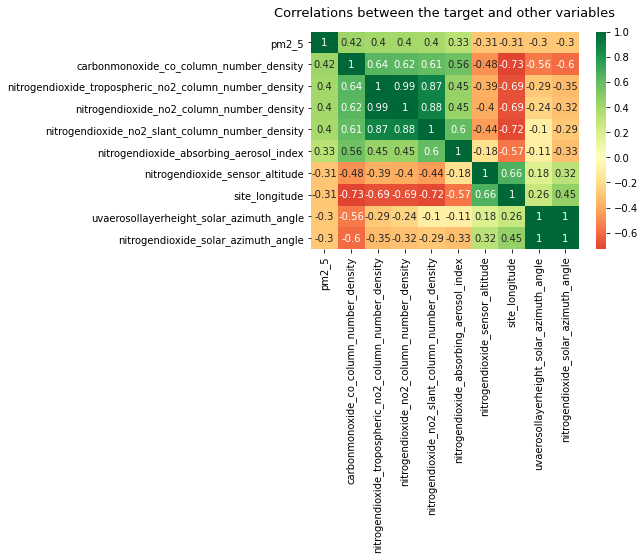

In [6]:
# Select only numerical features
train_num_df = train.select_dtypes(include=['number'])

top10_corrs = abs(train_num_df.corr()['pm2_5']).sort_values(ascending = False).head(10)
corr = train_num_df[list(top10_corrs.index)].corr()
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlations between the target and other variables', pad = 15, fontdict={'size': 13})
plt.show()

In [7]:
# The following are the chosen target variables for our model: 

xtarget_variables = ['id', 'site_id', 'city', 'country',
                    'hour', 'month', 'sulphurdioxide_so2_column_number_density', 'sulphurdioxide_so2_column_number_density_amf',
                    'sulphurdioxide_so2_slant_column_number_density', 'sulphurdioxide_so2_column_number_density_15km',
                    'carbonmonoxide_co_column_number_density', 'carbonmonoxide_h2o_column_number_density',
                    'nitrogendioxide_no2_column_number_density', 'nitrogendioxide_tropospheric_no2_column_number_density',
                    'nitrogendioxide_stratospheric_no2_column_number_density', 'nitrogendioxide_no2_slant_column_number_density',
                    'nitrogendioxide_absorbing_aerosol_index', 'formaldehyde_tropospheric_hcho_column_number_density',
                    'formaldehyde_tropospheric_hcho_column_number_density_amf', 'formaldehyde_hcho_slant_column_number_density',
                    'uvaerosolindex_absorbing_aerosol_index', 'ozone_o3_column_number_density', 'ozone_o3_column_number_density_amf',
                    'ozone_o3_slant_column_number_density', 'pm2_5']

target_variables = ['site_id', 'month', 'site_latitude', 'site_longitude', 'city', 'country',
       'hour', 'uvaerosollayerheight_aerosol_pressure', 'cloud_cloud_top_pressure', 
       'cloud_cloud_base_pressure', 'carbonmonoxide_cloud_height', 'uvaerosollayerheight_aerosol_height', 
        'nitrogendioxide_tropopause_pressure', 'carbonmonoxide_h2o_column_number_density', 
        'sulphurdioxide_so2_column_number_density', 
        'ozone_o3_column_number_density', 'pm2_5']

In [8]:
data = train[target_variables]
data

,site_id,month,site_latitude,site_longitude,city,country,hour,uvaerosollayerheight_aerosol_pressure,cloud_cloud_top_pressure,cloud_cloud_base_pressure,carbonmonoxide_cloud_height,uvaerosollayerheight_aerosol_height,nitrogendioxide_tropopause_pressure,carbonmonoxide_h2o_column_number_density,sulphurdioxide_so2_column_number_density,ozone_o3_column_number_density,pm2_5
date,,,,,,,,,,,,,,,,,
2023-10-25,6531a46a89b3300013914a36,10.0,6.532570,3.399360,Lagos,Nigeria,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.122055,12.015000
2023-11-02,6531a46a89b3300013914a36,11.0,6.532570,3.399360,Lagos,Nigeria,12,NaN,NaN,NaN,3399.756845,NaN,NaN,3771.027210,NaN,0.116975,42.267200
2023-11-03,6531a46a89b3300013914a36,11.0,6.532570,3.399360,Lagos,Nigeria,13,NaN,45185.499590,51171.802486,NaN,NaN,NaN,NaN,NaN,0.117559,39.450741
2023-11-08,6531a46a89b3300013914a36,11.0,6.532570,3.399360,Lagos,Nigeria,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.118412,10.537600
2023-11-09,6531a46a89b3300013914a36,11.0,6.532570,3.399360,Lagos,Nigeria,13,NaN,86197.531250,96215.906250,1678.370478,NaN,9582.712645,3514.042054,0.000267,0.117899,19.431731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17,647f3a5d69df500029a2fc93,1.0,-1.268877,36.819139,Nairobi,Kenya,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.104364,21.086071
2024-01-24,647f3a5d69df500029a2fc93,1.0,-1.268877,36.819139,Nairobi,Kenya,11,NaN,NaN,NaN,1874.310425,NaN,7311.869141,2062.178223,-0.000563,0.106309,17.110000
2024-01-25,647f3a5d69df500029a2fc93,1.0,-1.268877,36.819139,Nairobi,Kenya,11,NaN,NaN,NaN,1053.974365,NaN,NaN,1560.910767,NaN,0.108092,15.080000


In [9]:
train_drop = data.drop(['pm2_5'], axis=1)
cols = train_drop.columns.to_list()
data_test = test[cols]
data_test

,site_id,month,site_latitude,site_longitude,city,country,hour,uvaerosollayerheight_aerosol_pressure,cloud_cloud_top_pressure,cloud_cloud_base_pressure,carbonmonoxide_cloud_height,uvaerosollayerheight_aerosol_height,nitrogendioxide_tropopause_pressure,carbonmonoxide_h2o_column_number_density,sulphurdioxide_so2_column_number_density,ozone_o3_column_number_density
date,,,,,,,,,,,,,,,,
2023-09-06,64f9d17ab9e98d001ac9e882,9.0,5.61252,-0.22955,Accra,Ghana,13,NaN,74217.403083,83569.504246,1.000000,NaN,9582.745678,2825.323242,-0.000072,0.126056
2023-09-07,64f9d17ab9e98d001ac9e882,9.0,5.61252,-0.22955,Accra,Ghana,13,NaN,NaN,NaN,1584.809692,NaN,NaN,2604.788330,NaN,0.126282
2023-09-08,64f9d17ab9e98d001ac9e882,9.0,5.61252,-0.22955,Accra,Ghana,13,NaN,NaN,NaN,90.699029,NaN,9582.743944,3046.314001,-0.000051,0.126162
2023-09-09,64f9d17ab9e98d001ac9e882,9.0,5.61252,-0.22955,Accra,Ghana,12,NaN,46052.449219,52160.980469,NaN,NaN,NaN,NaN,NaN,0.121339
2023-09-20,64f9d17ab9e98d001ac9e882,9.0,5.61252,-0.22955,Accra,Ghana,12,NaN,NaN,NaN,NaN,NaN,8614.471169,NaN,-0.000634,0.127799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-27,64654b4dd5320e001d6c499a,1.0,-0.10098,34.76242,Kisumu,Kenya,10,NaN,59925.188475,67328.459370,1732.968059,NaN,7311.868969,1632.436685,0.000099,0.108112
2024-02-21,65c8c557b3d86f0012b2e32b,2.0,3.89696,11.50603,Yaoundé,Cameroon,12,NaN,68535.789382,77172.040801,NaN,NaN,NaN,NaN,NaN,0.110979
2024-02-22,65c8c557b3d86f0012b2e32b,2.0,3.89696,11.50603,Yaoundé,Cameroon,12,NaN,NaN,NaN,4783.710717,NaN,NaN,6486.587379,NaN,0.112540


In [10]:
# We select some columns to be renamed 

data = data.rename(columns={'sulphurdioxide_so2_column_number_density_amf':'SO2 amf', 'sulphurdioxide_so2_column_number_density': 'SO2 Density',
                             'nitrogendioxide_tropopause_pressure': 'NO2 Pressure',
                             'ozone_o3_column_number_density': 'O3 Density'
                             })

data_test = data_test.rename(columns={'sulphurdioxide_so2_column_number_density_amf':'SO2 amf', 'sulphurdioxide_so2_column_number_density': 'SO2 Density',
                             'nitrogendioxide_tropopause_pressure': 'NO2 Pressure',
                             'ozone_o3_column_number_density': 'O3 Density'
                             })


In [11]:
# Import LabelEncoder 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
 
# Create a boolean mask for categorical columns 
categorical_mask = (data.dtypes == object) 

# Get list of categorical column names 
categorical_columns =  data.columns[categorical_mask].tolist() 
numeric_columns =  data.select_dtypes(include=['number']).columns 
numeric_columns_test =  data_test.select_dtypes(include=['number']).columns 
# non_categorical_columns = X.columns[~categorical_feature_mask] .tolist()
 
# Print the head of the categorical columns 
print(data[categorical_columns].head()) 

                             site_id   city  country
date                                                
2023-10-25  6531a46a89b3300013914a36  Lagos  Nigeria
2023-11-02  6531a46a89b3300013914a36  Lagos  Nigeria
2023-11-03  6531a46a89b3300013914a36  Lagos  Nigeria
2023-11-08  6531a46a89b3300013914a36  Lagos  Nigeria
2023-11-09  6531a46a89b3300013914a36  Lagos  Nigeria


In [12]:
# Create LabelEncoder object: 
le = LabelEncoder() 
ohe = OneHotEncoder(sparse=False, handle_unknown = 'ignore')

# Apply LabelEncoder to categorical columns: le.fit(data[categorical_columns]) 
data[categorical_columns] = data[categorical_columns].apply(lambda x: le.fit_transform(x))
                  
data_test[categorical_columns] = data_test[categorical_columns].apply(lambda x: le.fit_transform(x))


In [13]:

ohe.fit(data[categorical_columns])

train_ohe_df = ohe.transform(data[categorical_columns])
test_ohe_df = ohe.transform(data_test[categorical_columns])

df_tr = pd.DataFrame(train_ohe_df, columns=ohe.get_feature_names_out(categorical_columns))
df_tr1 = pd.concat([df_tr, data[numeric_columns].reset_index(drop=True)], axis=1)
                    
df_ts = pd.DataFrame(test_ohe_df, columns=ohe.get_feature_names_out(categorical_columns))
df_ts1 = pd.concat([df_ts, data_test[numeric_columns_test].reset_index(drop=True)], axis=1)

In [14]:
df_tr1.shape, df_ts1.shape

((8071, 91), (2783, 90))

In [15]:
df_tr1.head()

,site_id_0,site_id_1,site_id_2,site_id_3,site_id_4,site_id_5,site_id_6,site_id_7,site_id_8,site_id_9,site_id_10,site_id_11,site_id_12,site_id_13,site_id_14,site_id_15,site_id_16,site_id_17,site_id_18,site_id_19,site_id_20,site_id_21,site_id_22,site_id_23,site_id_24,site_id_25,site_id_26,site_id_27,site_id_28,site_id_29,site_id_30,site_id_31,site_id_32,site_id_33,site_id_34,site_id_35,site_id_36,site_id_37,site_id_38,site_id_39,site_id_40,site_id_41,site_id_42,site_id_43,site_id_44,site_id_45,site_id_46,site_id_47,site_id_48,site_id_49,site_id_50,site_id_51,site_id_52,site_id_53,site_id_54,site_id_55,site_id_56,site_id_57,site_id_58,site_id_59,site_id_60,site_id_61,site_id_62,site_id_63,site_id_64,site_id_65,site_id_66,site_id_67,site_id_68,city_0,city_1,city_2,city_3,country_0,country_1,country_2,country_3,month,site_latitude,site_longitude,hour,uvaerosollayerheight_aerosol_pressure,cloud_cloud_top_pressure,cloud_cloud_base_pressure,carbonmonoxide_cloud_height,uvaerosollayerheight_aerosol_height,NO2 Pressure,carbonmonoxide_h2o_column_number_density,SO2 Density,O3 Density,pm2_5
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,10.0,6.53257,3.39936,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.122055,12.015000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,11.0,6.53257,3.39936,12,NaN,NaN,NaN,3399.756845,NaN,NaN,3771.027210,NaN,0.116975,42.267200
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,11.0,6.53257,3.39936,13,NaN,45185.49959,51171.802486,NaN,NaN,NaN,NaN,NaN,0.117559,39.450741
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,11.0,6.53257,3.39936,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.118412,10.537600
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,11.0,6.53257,3.39936,13,NaN,86197.53125,96215.906250,1678.370478,NaN,9582.712645,3514.042054,0.000267,0.117899,19.431731


In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def preprocess_data(df, target_column):
    # Separate target variable and features
    X = df.drop(columns=[target_column])   #  + ['id']
    y = df[target_column]

    # Identify numeric and categorical columns
    numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = X.select_dtypes(include=['object']).columns

    # Impute missing values
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())  # Using RobustScaler to handle outliers
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent'))  #  ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine transformers into a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    # Fit and transform the data
    X_processed = preprocessor.fit_transform(X)

    # Return the preprocessed feature matrix and target variable
    return pd.DataFrame(X_processed), y

In [17]:
target = 'pm2_5'
df_ts1['pm2_5'] = 0

X, y = preprocess_data(df_tr1, target)
X_sub, y_sub = preprocess_data(df_ts1, target)

# Create the training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y,
test_size=.3, random_state=123)

In [18]:
# Besthyperparameters: 
best_params = {'objective':'reg:squarederror', 'booster': 'gbtree', 'lambda': 0.34575178703443626,  
               'alpha': 0.0026262241044471405, 'max_depth': 7, 'eta': 0.040145329744489734, 
               'gamma': 0.051007586464397695, 'grow_policy': 'depthwise'}

#Trainthefinalmodel
model=xgb.XGBRegressor(**best_params)
model.fit(X_train,y_train)

# Predict the labels of the test set: preds
y_pred = model.predict(X_test)


#Evaluatethemodel
mse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)
print(f'Root Mean Squared Error(RMSE):{rmse}')

Root Mean Squared Error(RMSE):16.06606676351828


In [19]:
pred_X_test = model.predict(X_sub)

In [20]:
# Create submission file
sub = pd.DataFrame({'id': test['id'], 'pm2_5': pred_X_test})

# Preview sub file
sub.head()

# Create a csv file
sub.to_csv(DATA_PATH / 'submission.csv', index = False)


In [ ]:
import catboost as cbt

oof_pred= []
# fold_pred=[]

params = {'n_estimators':1200, 'max_depth': 10}

fold= KFold(n_splits=10, shuffle=True, random_state = 23)#15#5#10

i=1
for train_index, test_index in fold.split(X,y): 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = np.sqrt(y.iloc[train_index]), y.iloc[test_index]

    model = cbt.CatBoostRegressor(**params)
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100, verbose = False)#erly100

    preds= model.predict(X_test)
    print("err: ", (mean_squared_error(y_test,preds**2))**0.5)  #Reverse transformation
    oof_pred.append(mean_squared_error(y_test,preds**2)**0.5)



In [22]:
p2 = model.predict(X_sub[X.columns])
print(np.mean(oof_pred))

13.849860027104759


[00:12:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


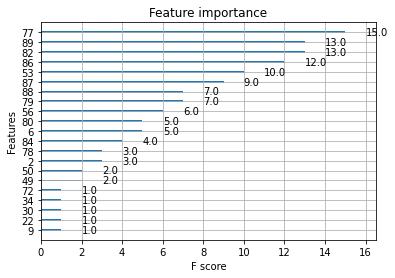

In [24]:

# Create the DMatrix: AirQo_dmatrix
airQo_dmatrix = xgb.DMatrix(X, label=y)
# Create the parameter dictionary: params
params = {"objective": "reg:linear", "max_depth":4}
# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=airQo_dmatrix, num_boost_round=10)
# Plot the feature importances
xgb.plot_importance(xg_reg, max_num_features=40)
plt.show()

In [27]:
from sklearn.model_selection import KFold

kfolds = KFold(n_splits=3)

data_df = X  # train

miss_col = data_df.columns[data_df.isnull().any()]

all_rmse =[]


# define model
model2 = LGBMRegressor(metric='rmse',n_estimators = 2000,learning_rate=0.1,max_depth=10)

t_rmse = 0
for train_index, test_index in kfolds.split(X, y):
    X_train_folds = X.iloc[train_index]
    y_train_folds = y.iloc[train_index]
    X_test_fold = X.iloc[test_index]
    y_test_fold = y.iloc[test_index]

    # Fit a model
    model2.fit(X_train_folds, y_train_folds)
    y_pred = model2.predict(X_test_fold)
    rmse = mean_squared_error(y_test_fold, y_pred)
    t_rmse = t_rmse + rmse
    
    m_rmse = t_rmse/kfolds.n_splits
    print(f"Mean RMSE: {m_rmse}")


all_rmse.append(m_rmse)

print(f"Mean RMSE: {all_rmse}")

Mean RMSE: 122.01864945401088
Mean RMSE: 508.15657469432546
Mean RMSE: 670.4913363213155
Mean RMSE: [670.4913363213155]


In [28]:
miss_col

Int64Index([], dtype='int64')